## Setup

Import modules.

In [ ]:
import math
import numpy as np
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10
import random
from google.colab import drive
from math import ceil

Set random seed for reproducibility

In [ ]:
manualSeed = 742
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  742


Set hyperparameters.

In [ ]:
batch_size  = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Mount Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data pre-processing

Define functions.



In [ ]:
# helper function to make getting another batch of data easier
# def cycle(iterable):
#     while True:
#         for x in iterable:
#             yield x

def get_data_of_class(class_name_lst, data):
  """Get subset of original data with a specific label (e.g., 'horse')"""
  target = [class_names.index(class_name) for class_name in class_name_lst]
  new_data_indices = [i for i in range(len(data)) if data[i][1] in target]
  new_data = torch.utils.data.Subset(data, new_data_indices)
  return new_data

def make_loader(data):
  return torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size, 
      drop_last=True)

Fetch CIFAR-10 dataset.

In [ ]:
train_data = torchvision.datasets.CIFAR10(
    'drive/My Drive/training/cifar10', train=True, download=True, 
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.Resize(32),
                                              # torchvision.transforms.Grayscale(),
                                              torchvision.transforms.ToTensor(),
    ]))

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


Create subsets.

In [ ]:
bird_data = get_data_of_class(['bird'], train_data)
horse_data = get_data_of_class(['horse'], train_data)
bird_and_horse_data = get_data_of_class(['bird', 'horse'], train_data)

Create loaders.

In [ ]:
train_loader = make_loader(train_data)
bird_loader = make_loader(bird_data)
horse_loader = make_loader(horse_data)
bird_and_horse_loader = make_loader(bird_and_horse_data)

Create iterators.

In [ ]:
# train_iterator = iter(cycle(train_loader))
# bird_train_iterator = iter(cycle(bird_loader))
# horse_train_iterator = iter(cycle(horse_loader))
# bird_and_horse_iterator = iter(cycle(bird_and_horse_loader))

## Data visualisation

In [ ]:
def plot_loader(loader, size=25):
  print(f'> Size of training dataset {len(loader.dataset)}')
  plt.figure(figsize=(10,10))
  for i in range(size):
    n_rows = ceil(size**0.5)
    n_cols = ceil(size/n_rows) 
    plt.subplot(n_rows, n_cols, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap='gray', vmin=0, vmax=255)
    # plt.imshow(loader.dataset[i][0][0], cmap=plt.cm.binary)
    plt.xlabel(class_names[loader.dataset[i][1]])

> Size of training dataset 10000


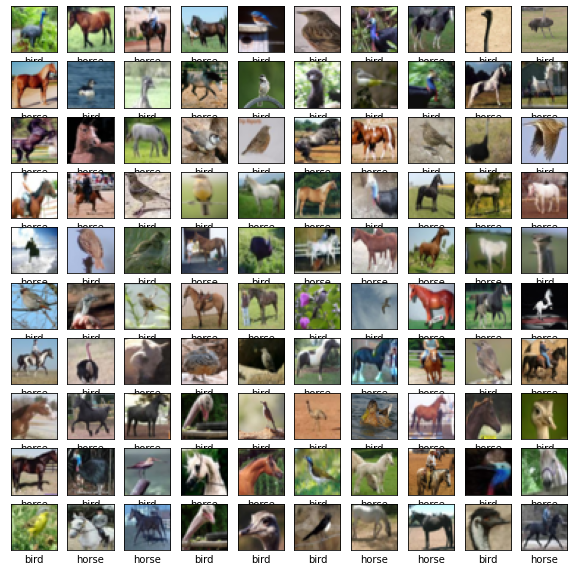

In [ ]:
plot_loader(bird_and_horse_loader, 100)

## Model definition

Define functions.

In [ ]:
def grayscale(x):
  """Takes a batch of RGB images and converts it to gresycale.

  Example:
    ```
    x,t = next(horse_train_iterator) 
    x,t = x.to(device), t.to(device) 
    x.shape 
    > torch.Size([64, 3, 32, 32]) 
    grayscale(x).shape 
    > torch.Size([64, 1, 32, 32])
    ```
  """
  rgb = (0.299 * x[:,0] + 0.587 * x[:,1] + 0.114 * x[:,2])
  return rgb.unsqueeze(1)

def weights_init(m):
  """initialises custom weights (for the generator and discriminator networks)"""
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

Define the generator.

In [ ]:
# hyperparameters
nz = 100
nf = 32
nc = 3

class Generator(nn.Module):
  """A generator that generates fake images.
  
  Maps the latent space vector (z) to a RGB image with the same size as the 
  training images (i.e. 3x32x32). 
  """
  def __init__(self, nz=nz, nf=nf, nc=nc):
    """Inits Generator network.

    The network is a series of strided two dimensional convolutional transpose 
    layers, each paired with a 2d batch norm layer and a relu activation. The 
    output of the generator is fed through a tanh function to return it to 
    the input data range of [−1,1].

    Args:
      nz (int): Size of latent space vector (z). 
      nf (int): Size of feature maps.
      nc (int): Number of channels in the training images.
    """
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, nf * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(nf * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(nf * 2, nf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf),
        nn.ReLU(True),
        nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, input):
    """  
    
    After the first layer, the state size is:  (nf*4) x 4 x 4.
    After the second layer, the state size is: (nf*2) x 8 x 8.
    After the third layer, the state size is:  (nf) x 16 x 16.
    After the fourth layer, the state size is: (nc) x 32 x 32.
    """
    return self.main(input)

Inspect generator output.

torch.Size([64, 3, 32, 32])
(3, 32, 32)


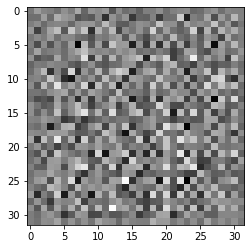

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)

for i, data in enumerate(horse_loader, start=0):
  if i > 0:
      break
  
  print(data[i].shape)

  real_cpu = data[0].to(device)
  batch_size = data[0].size(0)

  # Generate batch of latent vectors
  noise = torch.randn(batch_size, 100, 1, 1, device=device)
  # Generate fake image batch with G
  fake = netG(noise)

img = fake[0].cpu()
img = img.detach().numpy()
print(img.shape)
plt.imshow(img[0], cmap=plt.cm.binary)

Define the Discriminator

In [ ]:
class Discriminator(nn.Module):
  """A discriminator that classifies an image as fake or not.

  The discriminator is a binary classification network that takes a 3x32x32 
  image as input and outputs a scalr probability that the input image is 
  real.
  """ 
  def __init__(self, nc=nc, nf=nf):
    """Inits Discriminator network.
    
    The network is a series of Conv2d, BatchNorm2d, and LeakyReLU layers. The 
    output of the discriminator is fed through a Sigmoid activation function to
    obtain the final probability.

    Note:
      The DCGAN paper mentions it is a good practice to use strided convolution 
      rather than pooling to downsample because it lets the network learn its 
      own pooling function.

    Args:
      nc (int): Number of channels in the training images.
      nf (int): Size of feature maps.
    """
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(nf * 4, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
      )

  def forward(self, input):
    """Passes input through network.

    After the first layer, the state size is:  (nf) x 16 x 16
    After the second layer, the state size is: (nf*2) x 8 x 8.
    After the third layer, the state size is:  (nf*4) x 4 x 4.
    After the fourth layer, the state size is: 1

    Args:
      input: (nc) x 32 x 32
    """
    return self.main(input)

Binary Cross Entropy (BCE) loss is defined by PyTorch as: $$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],$$ where $N$ is the batch size. 

## Experimenting

> Size of training dataset 1


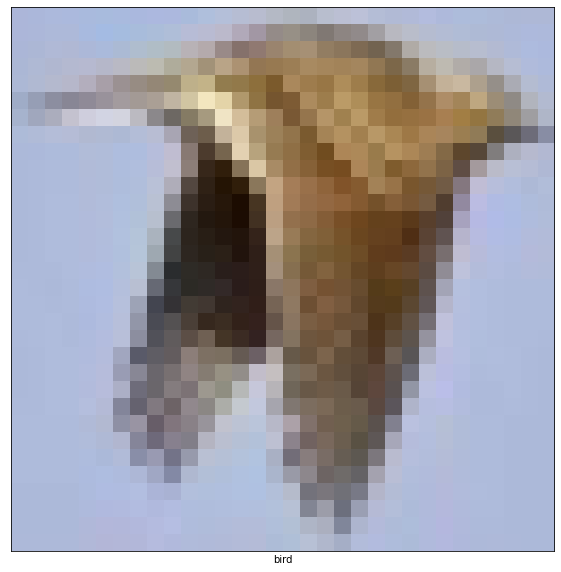

In [ ]:
handpicked_data = torch.utils.data.Subset(bird_and_horse_data, [29]) # [22, 29, 34, 39, 48, 96]
handpicked_loader = torch.utils.data.DataLoader(handpicked_data, shuffle=True, batch_size=batch_size)
plot_loader(handpicked_loader, 1)

In [ ]:
len(handpicked_data[0])
handpicked_data[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
for i, data in enumerate(handpicked_loader, start=0):
  if i > 0:
      break
  print(data[0].shape)

torch.Size([4, 3, 32, 32])


In [ ]:
x = torch.zeros(1, 2, 3)
x

tensor([[[0., 0., 0.],
         [0., 0., 0.]]])

In [ ]:
torch.tensor([[1, 2, 3]]).shape

torch.Size([1, 3])

In [ ]:
x = torch.zeros(1, 3, 32, 32)
x = x.repeat(4,1,1, 1)
# print(x)
print(x.shape)

torch.Size([4, 3, 32, 32])


In [ ]:
print(bird_loader.dataset[16][0].shape)

data = bird_loader.dataset[16][0]
data = data.repeat(64)

print(data.shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [ ]:
for i, data in enumerate(horse_loader, start=0):
  if i > 0:
      break

  print(data[0].shape)

torch.Size([64, 3, 32, 32])


## Main training loop

In [ ]:
# Create the generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

# Print the model
# print(netG)
# print(netD)

# hyperparameters
num_epochs = 100
dataloader = horse_loader
lr = 0.0002
beta1 = 0.5
fine_tune = False
limit = 5

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    if fine_tune == True and epoch > limit:
        dataloader = handpicked_loader
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)

        if fine_tune == True and epoch > limit:
            real_cpu = data[0].repeat(64, 1, 1, 1).to(device)
            print(real_cpu.size(0))

        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("Training stopped")

Starting Training Loop...
[0/100][0/78]	Loss_D: 1.3785	Loss_G: 1.0764	D(x): 0.5581	D(G(z)): 0.5203 / 0.3596
[0/100][50/78]	Loss_D: 0.5130	Loss_G: 4.6761	D(x): 0.8549	D(G(z)): 0.2707 / 0.0107
[1/100][0/78]	Loss_D: 0.2358	Loss_G: 3.3529	D(x): 0.8917	D(G(z)): 0.1061 / 0.0402
[1/100][50/78]	Loss_D: 0.5892	Loss_G: 2.0528	D(x): 0.7224	D(G(z)): 0.2068 / 0.1417
[2/100][0/78]	Loss_D: 0.7433	Loss_G: 1.8526	D(x): 0.6725	D(G(z)): 0.2569 / 0.1765
[2/100][50/78]	Loss_D: 0.3883	Loss_G: 2.5229	D(x): 0.7731	D(G(z)): 0.1076 / 0.0924
[3/100][0/78]	Loss_D: 1.0637	Loss_G: 1.1524	D(x): 0.4377	D(G(z)): 0.1014 / 0.3683
[3/100][50/78]	Loss_D: 0.6091	Loss_G: 2.7429	D(x): 0.7822	D(G(z)): 0.2774 / 0.0730
[4/100][0/78]	Loss_D: 0.6574	Loss_G: 2.0319	D(x): 0.7457	D(G(z)): 0.2724 / 0.1492
[4/100][50/78]	Loss_D: 0.5816	Loss_G: 2.0603	D(x): 0.7308	D(G(z)): 0.2038 / 0.1444
[5/100][0/78]	Loss_D: 0.9345	Loss_G: 2.0925	D(x): 0.6706	D(G(z)): 0.3675 / 0.1442
[5/100][50/78]	Loss_D: 0.8440	Loss_G: 2.6198	D(x): 0.7470	D(G(z)): 

## Results

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

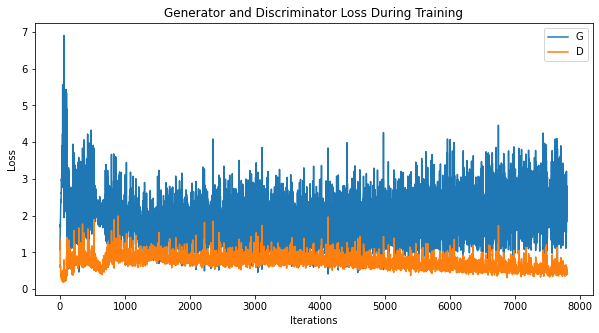

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

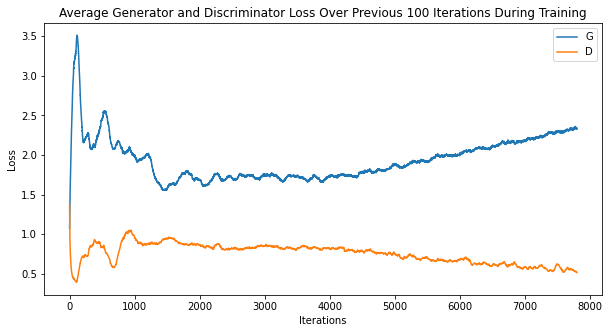

In [ ]:
def get_running_avg(losses):
  running_avg = np.zeros(len(losses))
  for i in range(len(running_avg)):
      running_avg[i] = np.mean(losses[max(0, i-100):(i+1)])
  return running_avg

running_avg_G_losses = get_running_avg(G_losses)
running_avg_D_losses = get_running_avg(D_losses)

plt.figure(figsize=(10,5))
plt.title("Average Generator and Discriminator Loss Over Previous 100 Iterations During Training")
plt.plot(running_avg_G_losses,label="G")
plt.plot(running_avg_D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

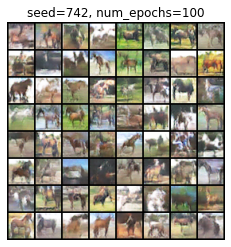

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
# plt.subplot(1,2,2)
plt.axis("off")
plt.title("seed={}, num_epochs={}".format(manualSeed, num_epochs))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()